In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/MyDrive/[2024-2025]AN2DL/Homework2


In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


In [3]:
%%capture
!pip install keras_cv
import keras_cv

In [4]:
# Charger le fichier .npz
data = np.load("mars_for_students.npz")

# Va bien nique ta mere
# Lister les clés disponibles
print("Clés disponibles dans le fichier :", data.files)

# Afficher la forme de chaque tableau
for key in data.files:
    print(f"Forme du tableau '{key}': {data[key].shape}")

Clés disponibles dans le fichier : ['training_set', 'test_set']
Forme du tableau 'training_set': (2615, 2, 64, 128)
Forme du tableau 'test_set': (10022, 64, 128)


In [5]:
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]  # Prend la première image pour chaque échantillon
y_train = training_set[:, 1, :, :]  # Prend la seconde image pour chaque échantillon


X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

image_shape = X_train[0].shape

print(f"Image shape: {image_shape}")




Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)
Image shape: (64, 128)


### find corrupted data

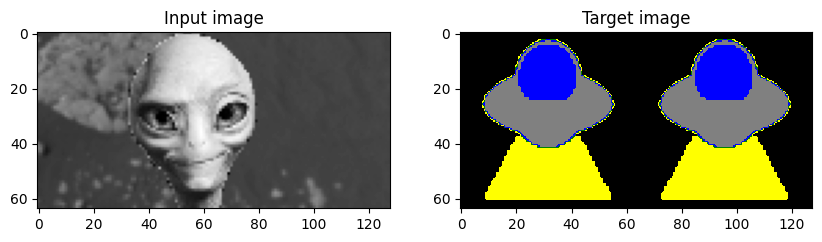

In [6]:

from matplotlib.colors import ListedColormap
# Display the corrupted data at index 348 in both X_train and y_train
index = 348
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(X_train[index], cmap="gray")
plt.title("Input image")
plt.subplot(122)
plt.imshow(y_train[index], cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
plt.title("Target image")
plt.show()

In [7]:
# find the number of occurences similar to the image at index 348 in the training set
# Compare all the image in y_train with the image at index 348, if they are equal, add the index to a list and increment a counter
similar_images = []
for i, image in enumerate(y_train):
    if np.array_equal(image, y_train[index]):
        similar_images.append(i)

print(f"Number of similar images: {len(similar_images)}")
print(f"Similar images indices: {similar_images}")



Number of similar images: 110
Similar images indices: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


### Removing corrupted data

In [8]:
# Remove all the corrupted data in y_train and X_train and register a new dataset
X_train_cleaned = np.delete(X_train, similar_images, axis=0)
y_train_cleaned = np.delete(y_train, similar_images, axis=0)

print(f"Cleaned Training X shape: {X_train_cleaned.shape}")
print(f"Cleaned Training y shape: {y_train_cleaned.shape}")


Cleaned Training X shape: (2505, 64, 128)
Cleaned Training y shape: (2505, 64, 128)


### Occurence per image

Number of occurences of each class in the cleaned dataset: {0: 2087, 1: 1281, 2: 1160, 3: 863, 4: 63}


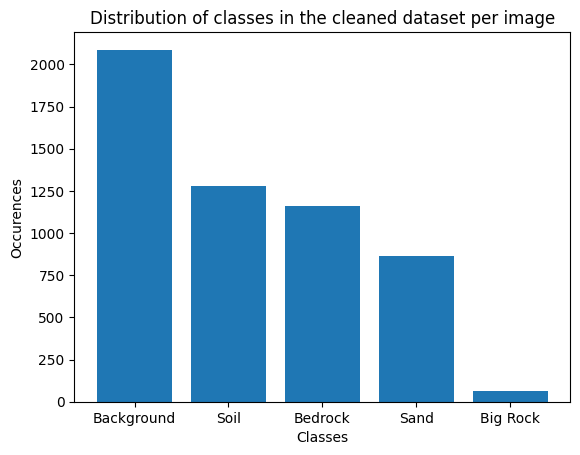

In [9]:
# Dic containing the number of occurences of each class in the cleaned dataset
occ = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

for image in y_train_cleaned:
    # detect if the image countains at least one pixel of a class
    for i in range(5):
        if i in image:
            occ[i] += 1


print(f"Number of occurences of each class in the cleaned dataset: {occ}")

# Display the distribution in a plot
plt.bar(class_labels.values(), occ.values())
plt.xlabel("Classes")
plt.ylabel("Occurences")
plt.title("Distribution of classes in the cleaned dataset per image")
plt.show()




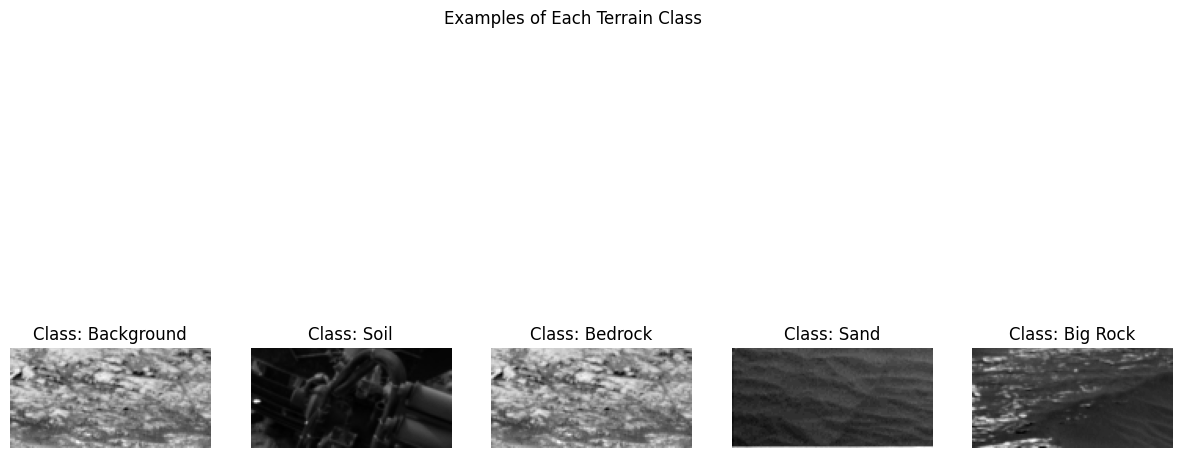

In [10]:
examples_per_class = {}

for i, image in enumerate(y_train_cleaned):
    unique_classes = np.unique(image)
    for cls in unique_classes:
        if cls not in examples_per_class:
            examples_per_class[cls] = X_train_cleaned[i]
    if len(examples_per_class) == len(class_labels):
        break

plt.figure(figsize=(15, 8))
for cls, example_image in examples_per_class.items():
    plt.subplot(1, len(class_labels), int(cls + 1))
    plt.imshow(example_image, cmap="gray")
    plt.title(f"Class: {class_labels[cls]}")
    plt.axis("off")
plt.suptitle("Examples of Each Terrain Class")
plt.show()

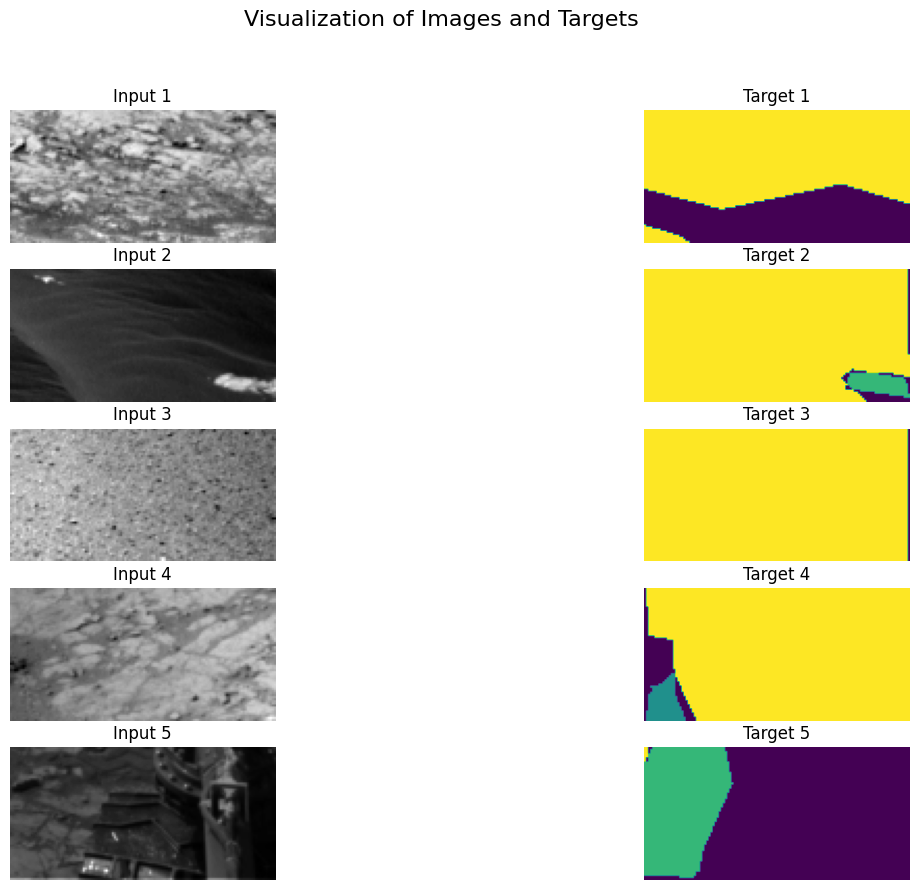

In [11]:
def visualize_examples(X, y, num_samples=5):
    """
    Visualize a few samples of input and target images side by side.
    Arguments:
    - X: input images
    - y: target images
    - num_samples: Number of samples to visualize
    """
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(X[-i], cmap="gray")
        plt.title(f"Input {i+1}")
        plt.axis("off")

        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(y[-i])
        plt.title(f"Target {i+1}")
        plt.axis("off")

    plt.suptitle("Visualization of Images and Targets", fontsize=16)
    plt.show()


visualize_examples(X_train_cleaned, y_train_cleaned, num_samples=5)

# Augmentation with Albumentation and Cut Mix


In [12]:
print(f"X_train_cleaned dtype: {X_train_cleaned.dtype}, range: {X_train_cleaned.min()}-{X_train_cleaned.max()}")
print(f"y_train_cleaned dtype: {y_train_cleaned.dtype}, range: {y_train_cleaned.min()}-{y_train_cleaned.max()}")

X_train_cleaned dtype: float64, range: 2.0-254.0
y_train_cleaned dtype: float64, range: 0.0-4.0


In [13]:
import albumentations as A
import random

def cutmix_segmentation(image_mask1, image_mask2, alpha=1.0):
    assert image_mask1['image'].shape == image_mask2['image'].shape, "Input images must have the same shape"
    assert image_mask1['mask'].shape == image_mask2['mask'].shape, "Mask images must have the same shape"

    # Sample lambda from Beta distribution
    lam = np.random.beta(alpha, alpha)

    # Determine the bounding box for the crop
    h, w = image_mask1['image'].shape[:2]
    cut_h = int(h * np.sqrt(1 - lam))
    cut_w = int(w * np.sqrt(1 - lam))

    cx = np.random.randint(0, w)
    cy = np.random.randint(0, h)

    x1 = np.clip(cx - cut_w // 2, 0, w)
    x2 = np.clip(cx + cut_w // 2, 0, w)
    y1_clip = np.clip(cy - cut_h // 2, 0, h)
    y2_clip = np.clip(cy + cut_h // 2, 0, h)

    # Create the CutMix image and target
    X_cutmix = image_mask1['image'].copy()
    y_cutmix = image_mask1['mask'].copy()

    X_cutmix[y1_clip:y2_clip, x1:x2] = image_mask2['image'][y1_clip:y2_clip, x1:x2]
    y_cutmix[y1_clip:y2_clip, x1:x2] = image_mask2['mask'][y1_clip:y2_clip, x1:x2]

    return X_cutmix, y_cutmix


def apply_augmentations(X, y):
    transform = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.RandomBrightnessContrast(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.3),
        A.GaussianBlur(blur_limit=(1, 5), p=0.1),
    ])

    X_augmented = []
    y_augmented = []

    # CutMix Augmentation
    NEW_IMG_CUTMIX = len(X) * 4
    for i in range(NEW_IMG_CUTMIX):
        ra = random.randint(0, len(X) - 1)
        rb = random.randint(0, len(X) - 1)
        while ra == rb:
            rb = random.randint(0, len(X) - 1)
        mixup_image, mixup_mask = cutmix_segmentation(
            {'image': X[ra], 'mask': y[ra]},
            {'image': X[rb], 'mask': y[rb]}
        )
        X_augmented.append(mixup_image)
        y_augmented.append(mixup_mask)

    # Albumentations
    for i in range(len(X_augmented)):
        augmented = transform(image=X_augmented[i], mask=y_augmented[i])
        X_augmented.append(augmented['image'])
        y_augmented.append(augmented['mask'])

    return np.array(X_augmented), np.array(y_augmented)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


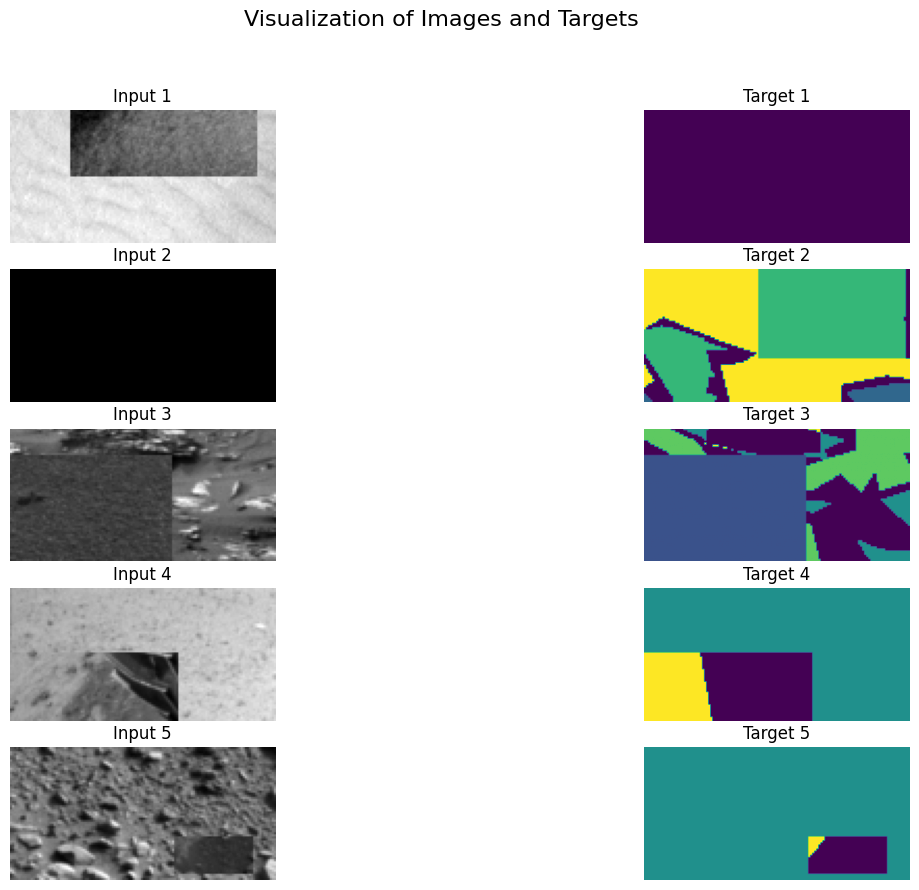

In [14]:
X_train_augmented, y_train_augmented = apply_augmentations(X_train_cleaned, y_train_cleaned)

visualize_examples(X_train_augmented, y_train_augmented, num_samples=5)

# Delete irrelevant images towards segmentation (images that are all the same color)

In [15]:
# Output the shapes of the datasets
print(f"Training X shape: {X_train_augmented.shape}")
print(f"Training y shape: {y_train_augmented.shape}")

def remove_single_color_images(X, y):
    valid_indices = []

    for i in range(len(X)):
        is_X_single_color = np.all(X[i] == X[i].flat[0])
        is_y_single_color = np.all(y[i] == y[i].flat[0])

        if not is_X_single_color and not is_y_single_color:
            valid_indices.append(i)

    X_cleaned = X[valid_indices]
    y_cleaned = y[valid_indices]

    return X_cleaned, y_cleaned


# Apply the function to clean the dataset
X_train_augmented_cleaned, y_train_augmented_cleaned = remove_single_color_images(X_train_augmented, y_train_augmented)

# Output the shapes of the cleaned datasets
print(f"Cleaned Training X shape: {X_train_augmented_cleaned.shape}")
print(f"Cleaned Training y shape: {y_train_augmented_cleaned.shape}")

Training X shape: (20040, 64, 128)
Training y shape: (20040, 64, 128)
Cleaned Training X shape: (18460, 64, 128)
Cleaned Training y shape: (18460, 64, 128)


In [16]:
# Add color channel and rescale pixels between 0 and 1
X_train_augmented_cleaned = X_train_augmented_cleaned[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

Processing segment: 1.0
Processing segment: 2.0
Processing segment: 3.0
Processing segment: 4.0


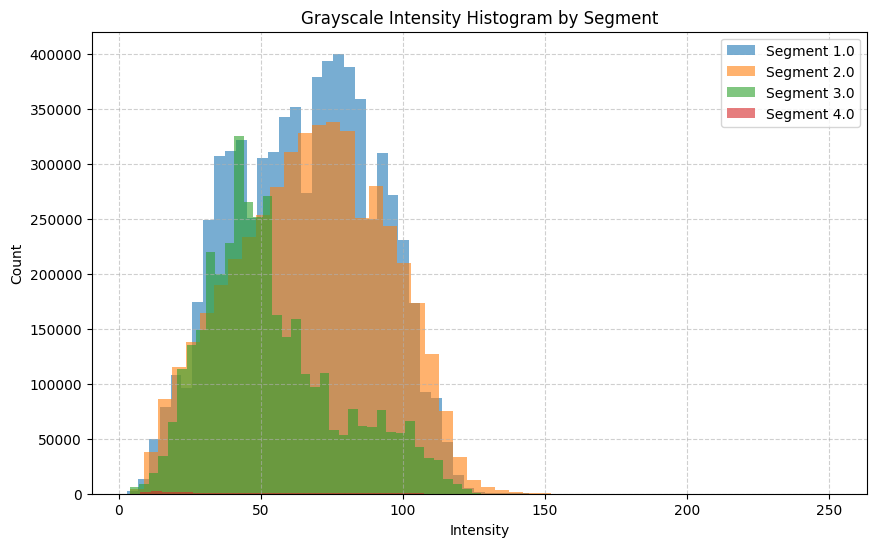

In [17]:
def plot_combined_grayscale_histogram(X_train_cleaned, y_train_cleaned):
    unique_segments = np.unique(y_train_cleaned)
    plt.figure(figsize=(10, 6))

    #drop background
    unique_segments = unique_segments[1:]

    for segment in unique_segments:
        print(f"Processing segment: {segment}")

        # Masking the images by the segment
        segment_pixels = []
        for img, mask in zip(X_train_cleaned, y_train_cleaned):
            segment_mask = mask == segment
            # Extract pixels corresponding to the current segment
            segment_pixels.append(img[segment_mask])

        # Combine all pixels of the segment across the dataset
        segment_pixels = np.concatenate(segment_pixels, axis=0)

        # Plot the histogram for the grayscale intensities
        plt.hist(
            segment_pixels,
            bins=50,
            alpha=0.6,
            label=f'Segment {segment}',
            histtype='stepfilled'
        )

    plt.title('Grayscale Intensity Histogram by Segment')
    plt.xlabel('Intensity')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Assuming X_train_cleaned and y_train_cleaned are preloaded
plot_combined_grayscale_histogram(X_train_cleaned, y_train_cleaned)


Processing segment: 1.0


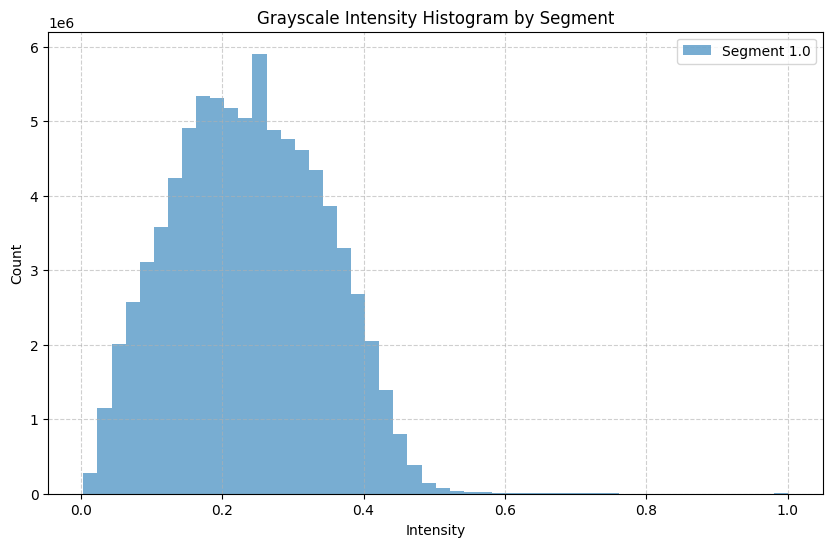

In [25]:
def plot_grayscale_histogram(X_train_cleaned, y_train_cleaned):
    unique_segments = np.unique(y_train_cleaned)
    plt.figure(figsize=(10, 6))

    for segment in unique_segments:
        print(f"Processing segment: {segment}")

        # Masking the images by the segment
        segment_pixels = []
        for img, mask in zip(X_train_cleaned, y_train_cleaned):
            segment_mask = mask == segment
            # Extract pixels corresponding to the current segment
            segment_pixels.append(img[segment_mask])

        # Combine all pixels of the segment across the dataset
        segment_pixels = np.concatenate(segment_pixels, axis=0)

        # Plot the histogram for the grayscale intensities
        plt.hist(
            segment_pixels,
            bins=50,
            alpha=0.6,
            label=f'Segment {segment}',
            histtype='stepfilled'
        )

    plt.title('Grayscale Intensity Histogram by Segment')
    plt.xlabel('Intensity')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
plot_grayscale_histogram(X_test, np.ones_like(X_test))


Total number of images: 2505
Number of images containing only one class: 425
Segment 0.0: 83.31% of images
Segment 1.0: 51.14% of images
Segment 2.0: 46.31% of images
Segment 3.0: 34.45% of images
Segment 4.0: 2.51% of images


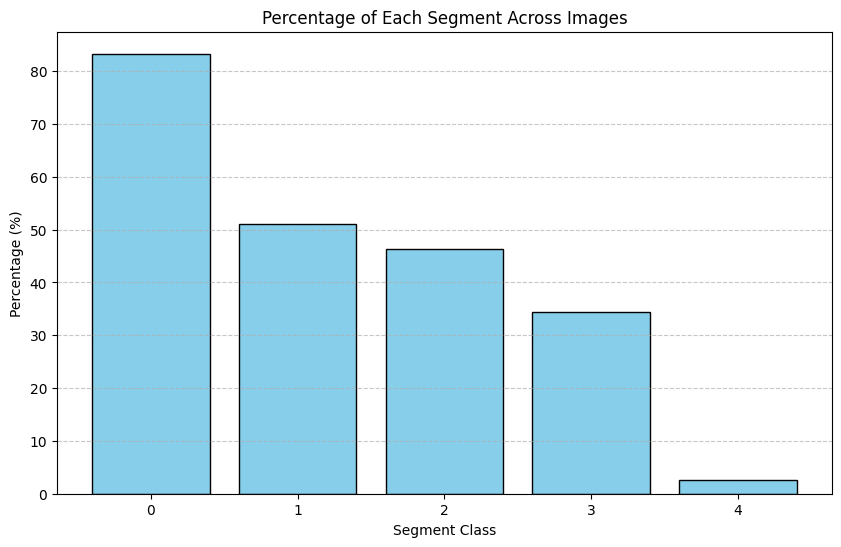

In [19]:
def analyze_segment_distribution(X_train_cleaned, y_train_cleaned):
    """
    Analyze and display segment distribution statistics.
    """
    # Flatten the segmentation masks to count segments in each image
    segment_counts = []
    single_class_images = 0

    for mask in y_train_cleaned:
        unique_segments = np.unique(mask)  # Unique segment classes in the image
        segment_counts.extend(unique_segments)  # Collect all unique segments
        if len(unique_segments) == 1:  # Check if it's a single-segment image
            single_class_images += 1

    # Count occurrences of each segment
    unique_segments, segment_frequencies = np.unique(segment_counts, return_counts=True)

    # Calculate percentage for each segment
    total_images = len(y_train_cleaned)
    segment_percentages = (segment_frequencies / total_images) * 100

    # Display Results
    print(f"Total number of images: {total_images}")
    print(f"Number of images containing only one class: {single_class_images}")

    for segment, percentage in zip(unique_segments, segment_percentages):
        print(f"Segment {segment}: {percentage:.2f}% of images")

    # Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_segments, segment_percentages, color='skyblue', edgecolor='black')
    plt.title('Percentage of Each Segment Across Images')
    plt.xlabel('Segment Class')
    plt.ylabel('Percentage (%)')
    plt.xticks(unique_segments)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Assuming X_train_cleaned and y_train_cleaned are preloaded
analyze_segment_distribution(X_train_cleaned, y_train_cleaned)

# Save Dataset

In [20]:
# Save the cleaned training data (X_train_cleaned, y_train_cleaned) and the test data (X_test)
#np.savez_compressed("mars_cleaned_and_augmented.npz", X_train=X_train_augmented_cleaned, y_train=y_train_augmented_cleaned, X_test=X_test)